In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.io import savemat

In [2]:
gamma = 1.5
cmap='nipy_spectral'

res_path = 'project'  
dat_path = 'grayresults'
scene_name = 'bunny'
gamma_diag = 2.2

sizeint = 1

In [3]:
def norm_im(im, blk, wht):
    im = (im - blk)/(wht - blk)
    im[im<0] = 0
    im[im>1] = 1
    return im

In [5]:
def read_epi_gc(dat_path, prefix):
    N_gc = 38 # number of graycode images
    fsize = 3

    # load captured patterns
    cap_full = []
    for i in range(N_gc):
        fn = os.path.join(dat_path, '%s_%02d.png'%(prefix, i))
        print(f"Loading image: {fn}")  # 경로 출력
        if not os.path.exists(fn):
            raise ValueError(f"Image at {fn} does not exist")
        im_full = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
        if im_full is None:
            raise ValueError(f"Image at {fn} could not be loaded")
        im_full = ndimage.median_filter(im_full, size=fsize)
        cap_full.append(im_full)
    return cap_full

def estimate_depth_graycode(cap_full):
    # parameters
    cam_shape = (360, 360) # row, column
    proj_shape = (360, 360) # row, column
    N_gc = 38 # number of graycode images
    N_tot = N_gc  # number of capture images (graycode + white + black)
    gc_step = 1 # should be 1 
    black_thr = 0
    white_thr = 0
    
    # captured patterns
    cap = []
    for cap_full_i in cap_full:
        im = np.zeros(cam_shape).astype(np.uint8)
        im = cap_full_i
        cap.append(im)
        
    # prepare simulation patterns
    gc_height = int((proj_shape[0]-1)/gc_step)+1    
    gc_width = int((proj_shape[1]-1)/gc_step)+1
    graycode = cv2.structured_light_GrayCodePattern.create(gc_width, gc_height)
    graycode.setBlackThreshold(black_thr)
    graycode.setWhiteThreshold(white_thr)
    
    R,C = im.shape
    
    # estimate the correspondence map
    corr = np.zeros((cam_shape[0], cam_shape[1], 2))
    cam_pts = []
    prj_pts = []
    valid_mask = np.zeros(cam_shape)
    for r in range(cam_shape[0]):
        if r%180  == 0:
            print('decoding %.2f'%(r/cam_shape[0]))
        for c in range(cam_shape[1]):
            err, proj_pix = graycode.getProjPixel(cap, c, r)
            if not err:
                corr[r,c] = np.array(proj_pix)
                cam_pts.append((c,r))
                prj_pts.append((proj_pix[0],proj_pix[1]))
                valid_mask[r,c] = True
    fig, ax = plt.subplots(2, 1, figsize=(5, 10))
    ax[0].imshow(corr[:,:,0], cmap='gray')
    ax[0].set_title("imshow(corr[:,:,0], cmap='gray')")
    ax[1].imshow(corr[:,:,1], cmap='gray')
    ax[1].set_title("imshow(corr[:,:,1], cmap='gray')")
    #vis
    img_shape = (360,360)
    cam_int = np.array([[679.20135993,   0.,        180.42103546],
     [  0.    ,     477.60244209 ,161.57014895],
     [  0.  ,         0.         ,  1.        ]])
    cam_dist = np.array([[ 1.87456684e-01, -5.15878503e+00, -7.10999945e-04 , 3.72761952e-04,    3.79331591e+01]])
    proj_int = np.array([[696.64676487, 0, 184.32586927],
     [0.00000000e+00, 491.29955121, 187.30105184],
     [0.00000000e+00, 0.00000000e+00, 1]])
    proj_dist = np.array([[-1.43700268e-01, 3.37063650e+00, -3.21586527e-03, 9.99112933e-04,    -2.26218830e+01]])
    cam_proj_rmat = np.array([[-9.99980127e-01, -2.04572363e-04, -6.30105438e-03],
    [-4.01369355e-04, -9.95379915e-01, 9.60138675e-02],
    [-6.29158476e-03, 9.60144885e-02, 9.95360052e-01]])
    cam_proj_tvec = np.array([[-6.17137471],
    [-11.90587551],
    [8.93748084]]) * sizeint

    # undistort points using calibration
    cam_pts = np.array(cam_pts, dtype=np.float32) 
    cam_pts = cam_pts.reshape((-1, 1, 2))
    cam_pts_n = cv2.undistortPoints(cam_pts, cam_int, cam_dist, P=cam_int)
    prj_pts = np.array(prj_pts, dtype=np.float32) 
    prj_pts = prj_pts.reshape((-1, 1, 2))
    prj_pts_n = cv2.undistortPoints(prj_pts, proj_int, proj_dist, P=proj_int)
    
    # triangulate
    P0 = np.dot(cam_int, np.array([[1,0,0,0],
                                   [0,1,0,0],
                                   [0,0,1,0]]))
    P1 = np.concatenate((np.dot(proj_int, cam_proj_rmat), np.dot(proj_int,cam_proj_tvec)), axis = 1)
    triang_res = cv2.triangulatePoints(P0, P1, cam_pts_n, prj_pts_n)
    points_3d = cv2.convertPointsFromHomogeneous(triang_res.T).squeeze()
    
    # xyz 
    cam_pts = cam_pts.astype(int)
    xyz = np.zeros((R,C,3))
    xyz[cam_pts[:,0,1], cam_pts[:,0,0], 0]=points_3d[:,0]
    xyz[cam_pts[:,0,1], cam_pts[:,0,0], 1]=points_3d[:,1]
    xyz[cam_pts[:,0,1], cam_pts[:,0,0], 2]=points_3d[:,2]
    xyz = xyz
    
    return xyz



Loading image: no_yes\result0_pattern_00.png
Loading image: no_yes\result0_pattern_01.png
Loading image: no_yes\result0_pattern_02.png
Loading image: no_yes\result0_pattern_03.png
Loading image: no_yes\result0_pattern_04.png
Loading image: no_yes\result0_pattern_05.png
Loading image: no_yes\result0_pattern_06.png
Loading image: no_yes\result0_pattern_07.png
Loading image: no_yes\result0_pattern_08.png
Loading image: no_yes\result0_pattern_09.png
Loading image: no_yes\result0_pattern_10.png
Loading image: no_yes\result0_pattern_11.png
Loading image: no_yes\result0_pattern_12.png
Loading image: no_yes\result0_pattern_13.png
Loading image: no_yes\result0_pattern_14.png
Loading image: no_yes\result0_pattern_15.png
Loading image: no_yes\result0_pattern_16.png
Loading image: no_yes\result0_pattern_17.png
Loading image: no_yes\result0_pattern_18.png
Loading image: no_yes\result0_pattern_19.png
Loading image: no_yes\result0_pattern_20.png
Loading image: no_yes\result0_pattern_21.png
Loading im

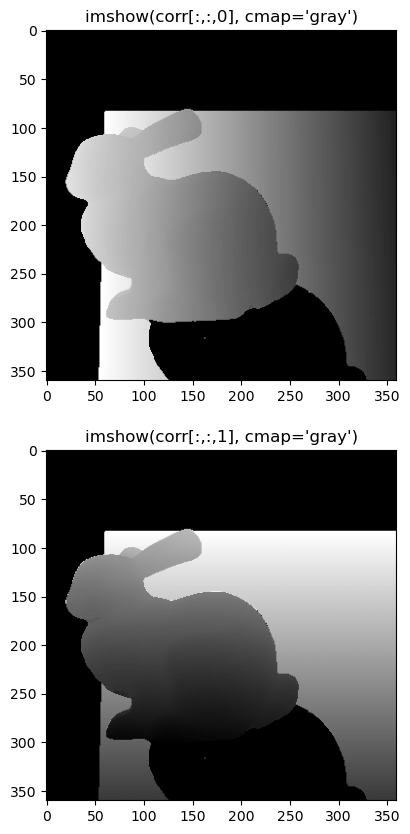

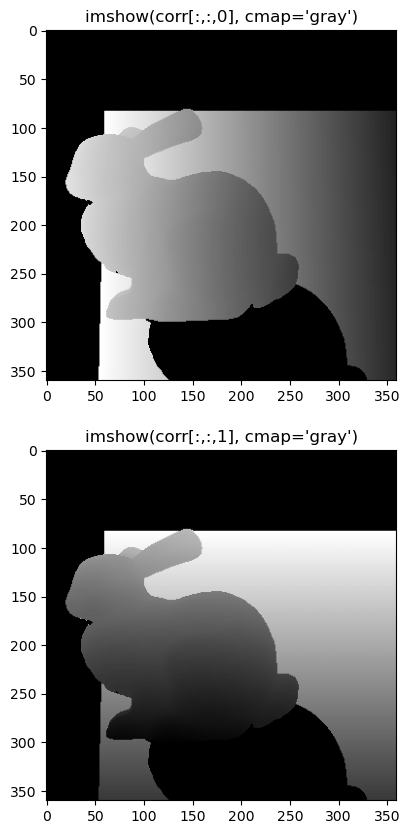

In [10]:
dmap_SL_pol = estimate_depth_graycode(read_epi_gc("no_yes", 'result0_pattern'))
dmap_SL = estimate_depth_graycode(read_epi_gc("no_no", 'resultpattern'))


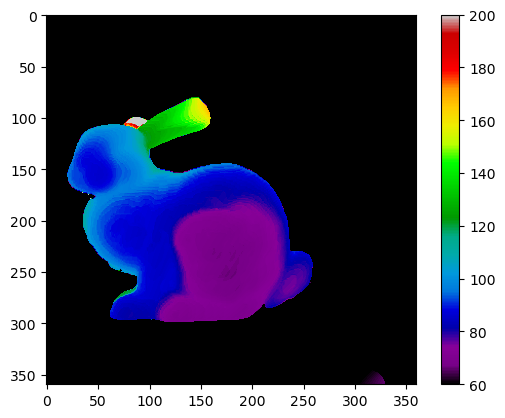

In [11]:
vmin = 60 * sizeint
vmax = 200* sizeint
# without vmin, vmax
# Vmin = 25, vmax = 55


plt.imshow(dmap_SL[...,2],vmin = vmin, vmax = vmax, cmap=cmap)
plt.colorbar()
# plt.savefig(os.path.join(res_path,'dmap_SL.svg'))
plt.show()
# savemat('dmap_SL.mat', {'dmap_SL':dmap_SL})

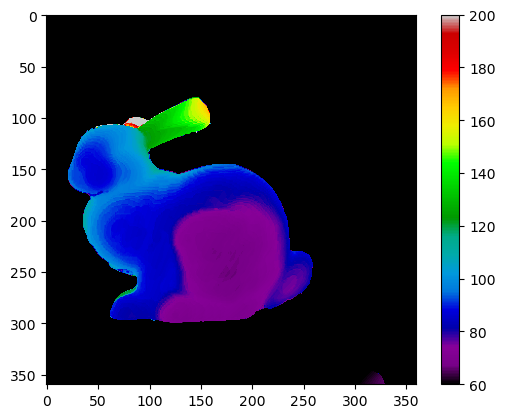

In [12]:
vmin = 60 * sizeint
vmax = 200* sizeint
# without vmin, vmax
# Vmin = 25, vmax = 55


plt.imshow(dmap_SL_pol[...,2],vmin = vmin, vmax = vmax, cmap=cmap)
plt.colorbar()
# plt.savefig(os.path.join(res_path,'dmap_SL.svg'))
plt.show()
# savemat('dmap_SL.mat', {'dmap_SL':dmap_SL})